# Quora Question-pair classification

네이버 지식인과 비슷한 싸이트인 Quora에 올라오는 질문들을 두 개씩 비교해서 같은 질문인지 아닌지 맞추는 대회

소스 출처 : https://www.kaggle.com/philschmidt/quora-eda-model-selection-roc-pr-plots

#  개관



질문쌍에 대한 TF-IDF 인코딩  

기본 피처 엔지니어링과 저차원 공간에서의 임베딩  

병렬 좌표 시각화

모델 선택 및 평가 + 샘플 제출.

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output

%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

print(check_output(["ls", "./data"]).decode("utf8"))


sample_submission.csv
test.csv
train.csv



In [7]:

df = pd.read_csv("./data/train.csv").fillna("")
df.head() 

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404290 non-null object
question2       404290 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [9]:
df.shape

(404290, 6)

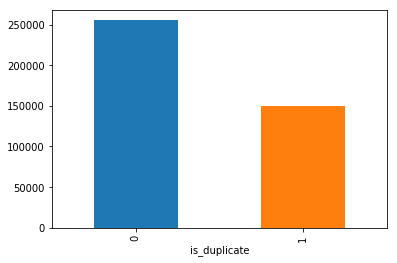

In [14]:
df.groupby("is_duplicate")['id'].count().plot.bar()

# Feature construction

1.  각 질문에 대해 표준 TF-IDF 인코딩

2. 계산상의 복잡성과 스토리지 요구 사항을 제한하기 위해 TF-IDF를 사용하여 모든 문서에서 상위 용어만 인코딩하고 나서 데이터의 하위 샘플도 살펴볼 것이다.

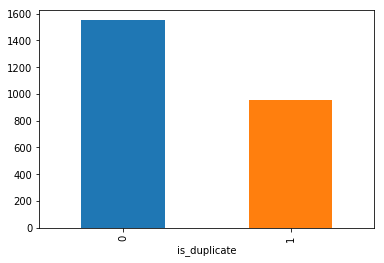

In [16]:
dfs = df[0:2500]
dfs.groupby("is_duplicate")['id'].count().plot.bar()

서브샘플이 비슷한 레이블을 분포를 보이고 있다. 더 깊어지기 전에 데이터의 첫번째만 살펴보는 것보다는 나은 샘플링을 수행한 셈이다.  

상위 50 %의 행에 질문 1 만 있고 하위 50 %에 질문 2만 있는 데이터 프레임을 만들 것이다. 이 데이터 프레임은 원래 데이터 프레임과 동일한 순서로 정렬되어 있어야 한다.

In [17]:
dfq1, dfq2 = dfs[['qid1', 'question1']], dfs[['qid2', 'question2']]
dfq1.columns = ['qid1', 'question']
dfq2.columns = ['qid2', 'question']

# merge two two dfs, there are two nans for question
dfqa = pd.concat((dfq1, dfq2), axis=0).fillna("")
nrows_for_q1 = dfqa.shape[0]/2
dfqa.shape

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False




(5000, 3)

## Transform questions by TF-IDF.

HashingVectorizer에 대한 공식 문서:   

http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html


### HashingVectorizer 장점:


메모리에 어휘 사전을 저장할 필요가 없으므로 매우 적은 메모리를 쓰면서 대규모 데이터 세트를 다룰 수 있다.  


constructor parameter 외에 다른 상태를 보유하지 않기 때문에 pickle 및 un-pickle이 빠르다.  


fit되는 동안에 계산하는 상태가 없기 때문에 streaming(부분 적합) 또는 병렬 파이프 라인에서 사용할 수 있다.


### HashingVectorizer 단점 (in-memory에서  단어의 CountVectorizer를 사용하는 것과 대비해서) 

모델에 어떤 기능이 가장 중요한가를 살펴 볼 때 문제가 될 수 있는 것으로 inverse transform (피쳐 인덱스에서 문자열 피쳐 이름으로)을 계산할 방법이 없다.


충돌하는 경우가 있다 : 서로 다른 토큰을 동일한 기능 인덱스에 매핑 할 수 있다. 그러나 n_features가 충분히 큰 경우인 (예 : 텍스트 분류 문제의 경우 2 ** 18)에는 실제로 문제가 되지 않는다.  


IDF 가중치가 없기 때문에 transformer가 자기 상태를 유지하게 된다.

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
mq1 = TfidfVectorizer(max_features = 256).fit_transform(dfqa['question'].values)
mq1

<5000x256 sparse matrix of type '<class 'numpy.float64'>'
	with 31365 stored elements in Compressed Sparse Row format>

In [19]:
diff_encodings = np.abs(mq1[::2] - mq1[1::2])
diff_encodings

<2500x256 sparse matrix of type '<class 'numpy.float64'>'
	with 29265 stored elements in Compressed Sparse Row format>

# 3D t-SNE embedding

t-SNE를 사용하여 TF-IDF 벡터를 3 차원으로 내장한 대화형 분산 플롯을 만들어 보자.

In [21]:
from sklearn.manifold import TSNE
tsne = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=300,
    verbose=2,
    angle=0.5
).fit_transform(diff_encodings.toarray())

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2500 samples in 0.028s...
[t-SNE] Computed neighbors for 2500 samples in 2.827s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2500
[t-SNE] Computed conditional probabilities for sample 2000 / 2500
[t-SNE] Computed conditional probabilities for sample 2500 / 2500
[t-SNE] Mean sigma: 0.466897
[t-SNE] Computed conditional probabilities in 0.088s
[t-SNE] Iteration 50: error = 122.7236633, gradient norm = 0.0446478 (50 iterations in 10.593s)
[t-SNE] Iteration 100: error = 126.7958450, gradient norm = 0.0664055 (50 iterations in 11.309s)
[t-SNE] Iteration 150: error = 129.8587341, gradient norm = 0.0439119 (50 iterations in 10.329s)
[t-SNE] Iteration 200: error = 136.8370514, gradient norm = 0.0270652 (50 iterations in 11.263s)
[t-SNE] Iteration 250: error = 137.9135437, gradient norm = 0.0200571 (50 iterations in 11.723s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 137.913544
[t-SNE] Iteratio

In [22]:
trace1 = go.Scatter3d(
    x=tsne[:,0],
    y=tsne[:,1],
    z=tsne[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = dfs['is_duplicate'].values,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='test')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

# Feature EDA

character length of questions 1 and 2  

number of words in question 1 and 2  

normalized word share count.  

In [23]:
df['q1len'] = df['question1'].str.len()
df['q2len'] = df['question2'].str.len()

df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))


df['word_share'] = df.apply(normalized_word_share, axis=1)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,word_share
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12,0.434783
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,8,13,0.200000
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,10,0.166667
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,11,9,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,13,7,0.100000


정규화된 어휘들(normalized word)이 오른쪽에 겹쳐 있는데, 많은 질문들에 유사성이 높은 단어가 많이 있지만 중복은 아니라고 해석할 수 있다.

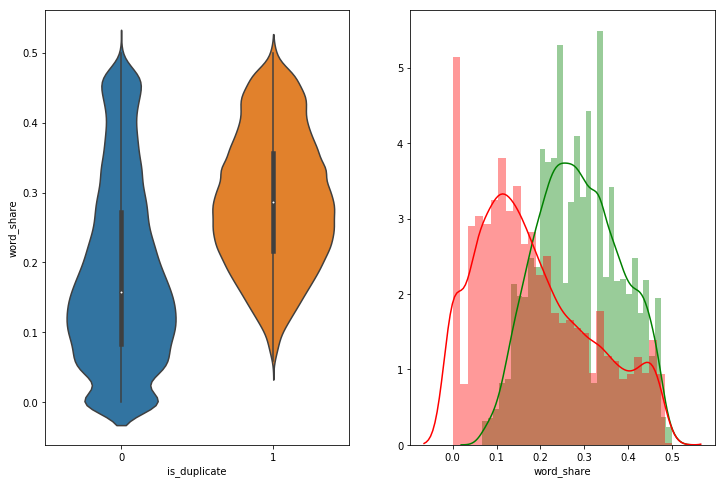

In [24]:
plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:50000])
plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:10000], color = 'green')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:10000], color = 'red')

스캐터 플랏에서 색상이 중복되는 부분의 질문쌍의 문자 길이는 우리가 이전에 계산한 word share coefficient의 크기를 보여준다.

In [25]:
df_subsampled = df[0:2000]

trace = go.Scatter(
    y = df_subsampled['q2len'].values,
    x = df_subsampled['q1len'].values,
    mode='markers',
    marker=dict(
        size= df_subsampled['word_share'].values * 60,
        color = df_subsampled['is_duplicate'].values,
        colorscale='Portland',
        showscale=True,
        opacity=0.5,
        colorbar = dict(title = 'duplicate')
    ),
    text = np.round(df_subsampled['word_share'].values, decimals=2)
)
data = [trace]

In [26]:
layout= go.Layout(
    autosize= True,
    title= 'Scatter plot of character lengths of question one and two',
    hovermode= 'closest',
        xaxis=dict(
        showgrid=False,
        zeroline=False,
        showline=False
    ),
    yaxis=dict(
        title= 'Question 2 length',
        ticklen= 5,
        gridwidth= 2,
        showgrid=False,
        zeroline=False,
        showline=False,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatterWords')

# Model starter

지금까지 구축 한 기본 기능으로 모델을 러닝할 것이다.

이를 위해 Logisitic 회귀 분석법을 사용할 것이다. 

CV, ROI 및 PR 곡선을 홀드 아웃 세트에 신속하게 입력하고 제출해 보자.

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(df[['q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_share']])

X = scaler.transform(df[['q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_share']])
y = df['is_duplicate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((270874, 5), (133416, 5), (270874,), (133416,))

Run cross-validation with a few hyper parameters.

In [29]:
clf = LogisticRegression()
grid = {
    'C': [1e-6, 1e-3, 1e0],
    'penalty': ['l1', 'l2']
}
cv = GridSearchCV(clf, grid, scoring='neg_log_loss', n_jobs=-1, verbose=1)
cv.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    8.6s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [1e-06, 0.001, 1.0], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=1)

validation 결과를 인쇄:  


어떤 정규식을 썼냐에 관계 없이 강하게 정규화된 모델이 다른 두 모델보다 훨씬 나쁜 negative log loss를 보이고 있다.


In [30]:
for i in range(1, len(cv.cv_results_['params'])+1):
    rank = cv.cv_results_['rank_test_score'][i-1]
    s = cv.cv_results_['mean_test_score'][i-1]
    sd = cv.cv_results_['std_test_score'][i-1]
    params = cv.cv_results_['params'][i-1]
    print("{0}. Mean validation neg log loss: {1:.3f} (std: {2:.3f}) - {3}".format(
        rank,
        s,
        sd,
        params
    ))

6. Mean validation neg log loss: -0.693 (std: 0.000) - {'C': 1e-06, 'penalty': 'l1'}
5. Mean validation neg log loss: -0.690 (std: 0.000) - {'C': 1e-06, 'penalty': 'l2'}
3. Mean validation neg log loss: -0.582 (std: 0.001) - {'C': 0.001, 'penalty': 'l1'}
4. Mean validation neg log loss: -0.586 (std: 0.001) - {'C': 0.001, 'penalty': 'l2'}
1. Mean validation neg log loss: -0.568 (std: 0.001) - {'C': 1.0, 'penalty': 'l1'}
2. Mean validation neg log loss: -0.569 (std: 0.001) - {'C': 1.0, 'penalty': 'l2'}


In [31]:
print(cv.best_params_)
print(cv.best_estimator_.coef_)

{'C': 1.0, 'penalty': 'l1'}
[[-13.52031902   4.28715738  10.33735805 -13.02923961   3.29717798]]


# ROC

ROC 커브는 위키 피디아의 설명과 그림 참고

https://en.wikipedia.org/wiki/Receiver_operating_characteristic

<img src="ROC_curves.svg" width="500"><BR>

Guora에 올라온 설명과 그림이 가장 이해가 쉽게 설명된 듯하다.

True Positive = Correctly identified  

True Negative = Correctly rejected  

True Negative = Correctly rejected  

False Positive = Incorrectly identified) 

https://www.quora.com/What-is-the-best-example-for-false-negative-false-positive-true-negative-and-true-positive-in-machine-learning

<img src="tpfp.png" width="500"><BR>

C: 1e-06, parameters [[-0.00424654 -0.00232424 -0.00354647 -0.00199886 -0.00186031]] and intercept [-0.03324687]
C: 0.0001, parameters [[-0.16061857 -0.09048901 -0.13250978 -0.07998846  0.68641435]] and intercept [-0.70401556]
C: 1.0, parameters [[-10.25339749  -0.91965233   6.77946553  -7.16268464   3.29874476]] and intercept [-1.34016168]


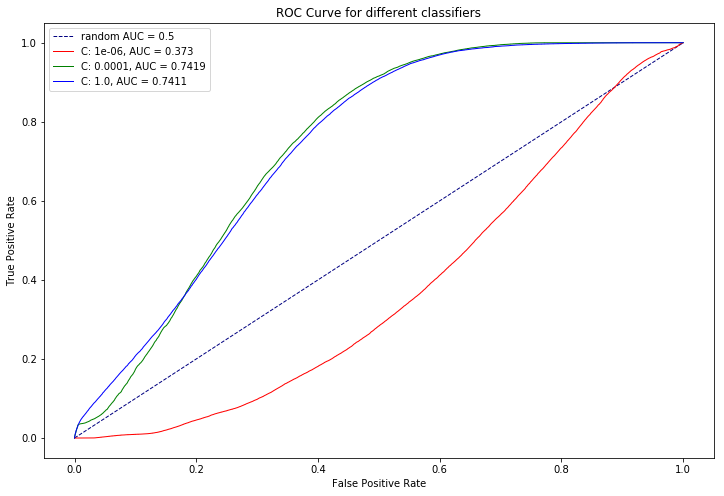

In [45]:
colors = ['r', 'g', 'b', 'y', 'k', 'c', 'm', 'brown', 'r']
lw = 1
Cs = [1e-6, 1e-4, 1e0]

plt.figure(figsize=(12,8))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for different classifiers')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

labels = []
for idx, C in enumerate(Cs):
    clf = LogisticRegression(C = C)
    clf.fit(X_train, y_train)
    print("C: {}, parameters {} and intercept {}".format(C, clf.coef_, clf.intercept_))
    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=colors[idx])
    labels.append("C: {}, AUC = {}".format(C, np.round(roc_auc, 4)))

plt.legend(['random AUC = 0.5'] + labels)

# Precision-Recall Curve

클래스 불균형이 있어 보인다.  


확실히 신뢰할 수 있는 몇몇 긍정적인 표본이 있다.  


중간 및 높은 리콜 지역에서 우리는  negatives와 분리하기 어려운 positives 샘플도 있음을 알 수 있습니다.

Text(0,0.5,'Precision')

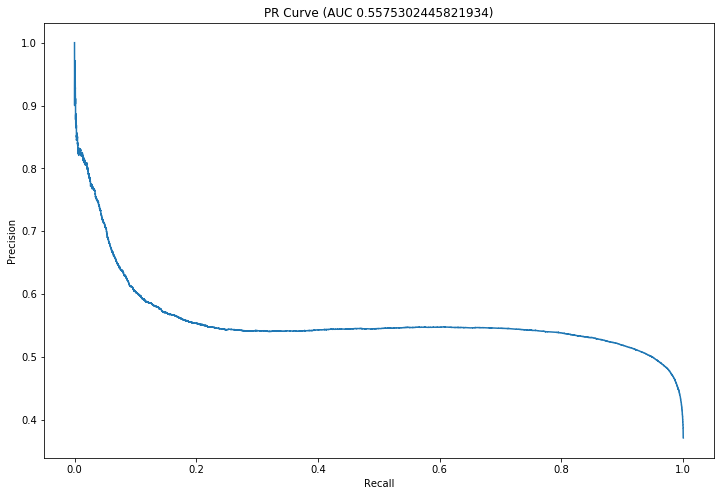

In [33]:
pr, re, _ = precision_recall_curve(y_test, cv.best_estimator_.predict_proba(X_test)[:,1])
plt.figure(figsize=(12,8))
plt.plot(re, pr)
plt.title('PR Curve (AUC {})'.format(auc(re, pr)))
plt.xlabel('Recall')
plt.ylabel('Precision')

# Prepare submission

1. 여기서 우리는 테스트 데이터를 읽고 우리가 훈련 데이터에 사용한 것과 동일한 변환을 적용한다.


2. features를 다시 스케일해야 한다.

In [36]:
dftest = pd.read_csv("./data/test.csv").fillna("")

dftest['q1len'] = dftest['question1'].str.len()
dftest['q2len'] = dftest['question2'].str.len()

dftest['q1_n_words'] = dftest['question1'].apply(lambda row: len(row.split(" ")))
dftest['q2_n_words'] = dftest['question2'].apply(lambda row: len(row.split(" ")))

dftest['word_share'] = dftest.apply(normalized_word_share, axis=1)

dftest.head()

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning:

Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.



,test_id,question1,question2,q1len,q2len,q1_n_words,q2_n_words,word_share
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...,57,68,11,14,0.083333
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?,66,43,14,7,0.190476
2,2,What but is the best way to send money from Ch...,What you send money to China?,60,29,14,6,0.222222
3,3,Which food not emulsifiers?,What foods fibre?,27,17,4,3,0.000000
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?,32,30,4,6,0.300000


전체 훈련 세트에서 최상의 하이퍼 매개 변수를 찾아서 cross-validation에서 발견된 최선의 추정량으로 재훈련 한다.


In [37]:
retrained = cv.best_estimator_.fit(X, y)

X_submission = scaler.transform(dftest[['q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_share']])

y_submission = retrained.predict_proba(X_submission)[:,1]

submission = pd.DataFrame({'test_id': dftest['test_id'], 'is_duplicate': y_submission})
submission.head()

,test_id,is_duplicate
0,0,0.162152
1,1,0.355267
2,2,0.437645
3,3,0.153527
4,4,0.509470


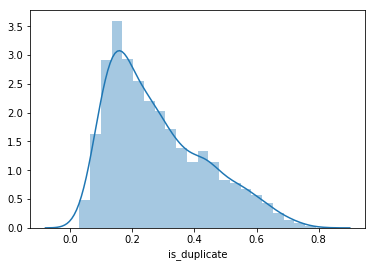

In [38]:
sns.distplot(submission.is_duplicate[0:2000])

In [39]:
submission.to_csv("submission.csv", index=False)

결과가 아주 좋지는 않지만 피처 엔지니어링이 좀 더 필요한 것으로 생각하고 만족 :)